<a href="https://colab.research.google.com/github/Leomutz/NIDS1/blob/main/2024_08_December_NSL_KDD_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#! pip install tab2img
#!pip install tensorflow==2.12.0

#!pip install prettytable
#!pip install tensorrt

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, MaxPool1D, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from tab2img.converter import Tab2Img
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from prettytable import PrettyTable
from scipy.stats import loguniform, randint, uniform
from pprint import pprint

from keras.regularizers import l2
#keras.utils.set_random_seed(812)

from sklearn.model_selection import KFold

In [5]:
# load the dataset
df_train = pd.read_csv('KDDTrain+.txt', header=None)
df_test = pd.read_csv('KDDTest+.txt', header=None)
#df_train20 = pd.read_csv('KDDTrain+_20Percent.txt', header=None)

In [6]:
# check the shape of the dataset
print(df_train.shape, df_test.shape)

(125973, 43) (22544, 43)


In [7]:
# add columns in the train dataset
df_train.columns = ['duration','protocol_type','service','flag','src_bytes','dst_byte','land','wrong_fragment',
                    'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
                    'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_logins',
                    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
                    'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_srv_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
        'dst_host_rerror_rate','dst_host_srv_rerror_rate','class','difficulty_level']

# add columns in the test dataset
df_test.columns = ['duration','protocol_type','service','flag','src_bytes','dst_byte','land','wrong_fragment',
                    'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
                    'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_logins',
                    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
                    'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_srv_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
        'dst_host_rerror_rate','dst_host_srv_rerror_rate','class','difficulty_level']

In [8]:
# identify the missing values
df_train.isnull().values.any(), df_test.isnull().values.any()

(False, False)

In [9]:
#get binary columns
binary_train = [col for col in df_train if (len(df_train[col].value_counts()) > 0) & all(df_train[col].value_counts().index.isin([0, 1]))]
binary_test = [col for col in df_test if (len(df_test[col].value_counts()) > 0) & all(df_test[col].value_counts().index.isin([0, 1]))]

print(f'Binary columns in:\n Training dataset are: {len(binary_train)}\n Test dataset are: {len(binary_test)}')

Binary columns in:
 Training dataset are: 6
 Test dataset are: 6


In [10]:
discrete_train = df_train.select_dtypes(include=['int']).columns.tolist()
continuous_train = df_train.select_dtypes(include=['float']).columns.tolist()

print('Dicrete data', len(discrete_train))
print('Continuous data',len(continuous_train))

Dicrete data 24
Continuous data 15


In [11]:
#get categorical columns
cat_train = df_train.select_dtypes(include=['object']).columns.tolist()
cat_test = df_test.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical columns in:\n Training dataset are: {len(cat_train)}\n Test dataset are: {len(cat_test)}')

Categorical columns in:
 Training dataset are: 4
 Test dataset are: 4


In [12]:
# categorical columns
cat_train

['protocol_type', 'service', 'flag', 'class']

In [13]:
oh= OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# train dataset
one_hot_encoded_train=oh.fit_transform(df_train[['protocol_type', 'service', 'flag']])
df_train_ohe = pd.concat([df_train,one_hot_encoded_train],axis=1).drop(columns=['protocol_type', 'service', 'flag'])
# test dataset only Transform (without fit)
one_hot_encoded_test=oh.transform(df_test[['protocol_type', 'service', 'flag']])
df_test_ohe = pd.concat([df_test,one_hot_encoded_test],axis=1).drop(columns=['protocol_type', 'service', 'flag'])

In [14]:
df_train_ohe.shape, df_test_ohe.shape

((125973, 124), (22544, 124))

In [15]:
# verify the columns in train and test sets are the same
print(all(x == y for x, y in zip(df_test_ohe.columns, df_train_ohe.columns)))  # Output: True

True


In [16]:
#copy data from the original
df_data_train = df_train_ohe.copy()
df_data_test = df_test_ohe.copy()
df_data_train.shape, df_data_test.shape

((125973, 124), (22544, 124))

In [17]:
df_data_train['class'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [18]:
#fixing labels on the training column 'class'
classlist_train = []
#attack1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
attack1 = ('back', 'land', 'neptune', 'pod', 'smurf', 'teardrop')
#attack2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
attack2 = ('ipsweep', 'nmap', 'portsweep', 'satan')
#attack3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
attack3 = ('buffer_overflow', 'loadmodule', 'perl', 'rootkit')
#attack4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")
attack4 = ('ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster')


# initialize the count of each attack category
DoS = 0;Probe = 0;U2R = 0;R2L = 0;Normal = 0

for i in df_data_train['class']:
  if i in attack1:
    classlist_train.append('DoS')
    DoS += 1
  elif i in attack2:
    classlist_train.append('Probe')
    Probe += 1
  elif i in attack3:
    classlist_train.append('U2R')
    U2R += 1
  elif i in attack4:
    classlist_train.append('R2L')
    R2L += 1
  else:
    classlist_train.append('Normal')
    Normal += 1
print('Number of attacks in groups (Training dataset):\n')
print('DoS:{}, Probe:{}, U2R:{}, R2L:{}, Normal:{}'.format(DoS, Probe, U2R, R2L, Normal))

Number of attacks in groups (Training dataset):

DoS:45927, Probe:11656, U2R:52, R2L:995, Normal:67343


In [19]:
df_data_test['class'].unique()

array(['neptune', 'normal', 'saint', 'mscan', 'guess_passwd', 'smurf',
       'apache2', 'satan', 'buffer_overflow', 'back', 'warezmaster',
       'snmpgetattack', 'processtable', 'pod', 'httptunnel', 'nmap', 'ps',
       'snmpguess', 'ipsweep', 'mailbomb', 'portsweep', 'multihop',
       'named', 'sendmail', 'loadmodule', 'xterm', 'worm', 'teardrop',
       'rootkit', 'xlock', 'perl', 'land', 'xsnoop', 'sqlattack',
       'ftp_write', 'imap', 'udpstorm', 'phf'], dtype=object)

In [20]:
#fixing labels on the testing column 'class'

classlist_test = []

#attack1 = ('apache2','arppoison','back','crashiis','desnuke','land','mailbomb','neptune','pod','processtable','selfping','smurf','syslogd','teardrop','tepreset','ucpstorm','udpstorm')
attack1 = ('apache2','back','mailbomb','neptune','pod','processtable','smurf','teardrop','udpstorm','land')
#attack2 = ('illegal-sniffer','ipsweep','lsdomain','mscan','msscan','nmap','ntinfoscan','portsweep','queso','saint','satan')
attack2 = ('ipsweep','mscan','nmap','portsweep','saint','satan')
#attack3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack",'worm',"xterm")
#attack3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
attack3 = ('buffer_overflow','httptunnel','loadmodule','perl','ps','rootkit','sqlattack','xterm')

#attack4 = ('ftp_write','ftpwrite','guess_passwd','guest', 'httptunnel','imap','multihop','named','ncftp','netbus','netcat','ppmacro','sendmail','spy','snmpguess','snmpgetattack','phf','warezclient','warezmaster','xlock','xsnoop')
#attack4 = ('ftp_write','guess_passwd','httptunnel','imap','multihop','named','sendmail','snmpguess','snmpgetattack','phf','warezmaster','xlock','xsnoop')
attack4 = ('ftp_write','guess_passwd','imap','multihop','named','sendmail','snmpguess','snmpgetattack','phf','warezmaster','xlock','xsnoop','worm')

# initialize the count of each attack category
DoS = 0;Probe = 0;U2R = 0;R2L = 0;Normal = 0

for i in df_data_test['class']:
  if i == 'normal':
    classlist_test.append('Normal')
    Normal += 1

  elif i in attack2:
    classlist_test.append('Probe')
    Probe += 1

  elif i in attack1:
    classlist_test.append('DoS')
    DoS += 1
  elif i in attack4:
    classlist_test.append('R2L')
    R2L += 1

  elif i in attack3:
    classlist_test.append('U2R')
    U2R += 1


####

print('Number of attacks in groups (Test dataset):\n')
print('DoS:{}, Probe:{}, U2R:{}, R2L:{}, Normal:{}'.format(DoS, Probe, U2R, R2L, Normal))

Number of attacks in groups (Test dataset):

DoS:7458, Probe:2421, U2R:200, R2L:2754, Normal:9711


In [21]:
#view the class list
classlist_train[:5], classlist_test[:5]

(['Normal', 'Normal', 'DoS', 'Normal', 'Normal'],
 ['DoS', 'DoS', 'Normal', 'Probe', 'Probe'])

In [22]:
# now append the class column to the dataFrames
df_data_train['class'] = classlist_train
df_data_test['class'] = classlist_test

In [23]:
#verify categorical variables
#only the label class
df_data_train.select_dtypes('object').head()

,class
0,Normal
1,Normal
2,DoS
3,Normal
4,Normal


In [24]:
#verify categorical variables
#only the label class
df_data_test.select_dtypes('object').head()

,class
0,DoS
1,DoS
2,Normal
3,Probe
4,Probe


In [25]:
#separate labels from the dataset
y_train = df_data_train.pop('class')

# the remaining data will be X
X_train = df_data_train
print(X_train.shape, y_train.shape)

(125973, 123) (125973,)


In [26]:
#separate labels from the dataset
y_test = df_data_test.pop('class')

# the remaining data will be X
X_test = df_data_test
print(X_test.shape, y_test.shape)

(22544, 123) (22544,)


In [27]:
# encoding labels function

# binary classification (0 for normal and 1 for attack)
def attack_encode_bin(attack):
  if attack == 'Normal':
    return 0
  else:
    return 1

# multi-class classification

# multi-labels (0,1,2,3,4)
def attack_encode_mult(attack):
  if attack == 'Normal':
    return 0
  elif attack == 'DoS':
    return 1
  elif attack == 'Probe':
    return 2
  elif attack == 'U2R':
    return 3
  else:
    return 4

In [29]:
# binary classification labels
y_train_bin = y_train.apply(attack_encode_bin)
print(y_train_bin.unique())

[0 1]


In [30]:
# binary classification labels
y_test_bin = y_test.apply(attack_encode_bin)
print(y_test_bin.unique())

[1 0]


In [31]:
# multi-class classification labels
y_train_mult = y_train.apply(attack_encode_mult)
print(y_train_mult.unique())

[0 1 4 2 3]


In [32]:
# multi-class classification labels
y_test_mult = y_test.apply(attack_encode_mult)
print(y_test_mult.unique())

[1 0 2 4 3]


In [33]:
# binarize labels for multi-class
y_train_mult_b = LabelBinarizer().fit_transform(y_train_mult)
print(y_train_mult_b[:3])

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]


In [34]:
# binarize labels for multi-class
y_test_mult_b = LabelBinarizer().fit_transform(y_test_mult)
print(y_test_mult_b[:3])

[[0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]]


In [35]:
type(y_train_mult_b),type(y_test_mult_b), type(y_test_mult), type(y_test_mult.values)

(numpy.ndarray, numpy.ndarray, pandas.core.series.Series, numpy.ndarray)

In [36]:
X_train.shape, X_test.shape

((125973, 123), (22544, 123))

In [37]:
X_train

,duration,src_bytes,dst_byte,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
125969,8,105,145,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
125970,0,2231,384,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
125971,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#scaler = MinMaxScaler(feature_range=(0,255))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
X_train

array([[0.00000000e+00, 3.55806412e-07, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.05799870e-07, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.61670897e-06, 2.93143779e-07, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.09423153e-07, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [40]:
y_test_mult.values

array([1, 1, 0, ..., 1, 0, 2])

In [41]:
# convert dataset into images
# training dataset
model_nsl = Tab2Img()
images_mult_train = model_nsl.fit_transform(X_train, y_train_mult.values)

In [42]:
# convert dataset into images
# test dataset
images_mult_test = model_nsl.transform(X_test)

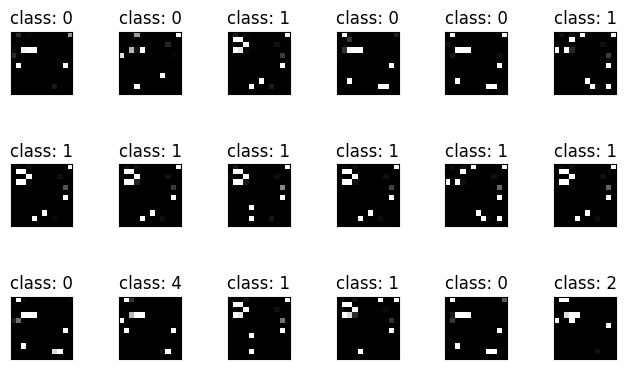

In [43]:
# Visualize the dataset
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.tight_layout()
    plt.imshow(images_mult_train[i], cmap='gray', interpolation='none')
    plt.title('class: {}'.format(y_train_mult.values[i]))
    plt.yticks([])
    plt.xticks([])

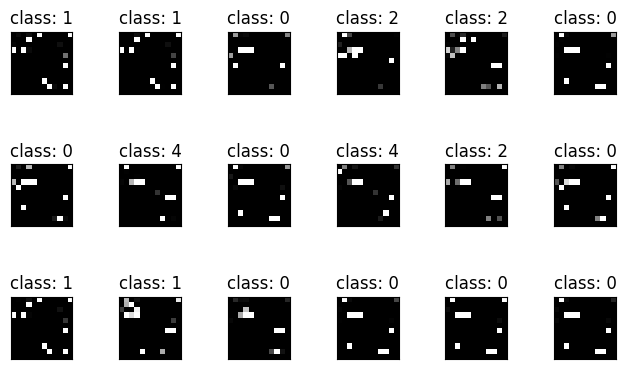

In [44]:
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.tight_layout()
    plt.imshow(images_mult_test[i], cmap='gray', interpolation='none')
    plt.title('class: {}'.format(y_test_mult.values[i]))
    plt.yticks([])
    plt.xticks([])

In [45]:
images_mult_train.shape, images_mult_test.shape

((125973, 12, 12), (22544, 12, 12))

In [46]:
# reshaping
X_train_f = images_mult_train.reshape(images_mult_train.shape[0], images_mult_train.shape[1],images_mult_train.shape[2], 1)
X_test_f = images_mult_test.reshape(images_mult_test.shape[0],images_mult_test.shape[1],images_mult_test.shape[2], 1)

In [47]:
X_train_f.shape, X_test_f.shape

((125973, 12, 12, 1), (22544, 12, 12, 1))

In [48]:
# scaling to [0,1]
X_train_f = X_train_f/255
X_test_f = X_test_f/255

In [49]:
def get_cnn_model(dropout=0.45, learning_rate=0.01, decay=1e-6):
  # multi-class classification

  model_mult = Sequential()
  model_mult.add(Conv2D(32,3,padding='same', input_shape=(12,12,1),activation='relu'))
  model_mult.add(BatchNormalization())
  model_mult.add(MaxPool2D((2,2)))

  model_mult.add(Conv2D(64,3,padding='same',activation='relu'))
  model_mult.add(BatchNormalization())
  model_mult.add(MaxPool2D((2,2)))


  model_mult.add(Conv2D(128,3,padding='same',activation='relu'))
  model_mult.add(BatchNormalization())

  model_mult.add(Flatten())
  model_mult.add(Dense(1000, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(500, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(250, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(125, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(50, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(units=5, activation='softmax'))

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)
  model_mult.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

  return model_mult

In [50]:
# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

In [51]:
'''
batch_size = [32, 64, 128]
dropout = [0.4, 0.45, 0.5]
learning_rate = loguniform(1e-6, 1e-3)
decay = loguniform(1e-7, 1e-4)
epochs = 150
'''

'''
param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'batch_size': randint(16, 256),
    #'decay': loguniform(1e-6, 0.1),
    'dropout': uniform(0.3, 0.5)
}
'''
param_dist = {
    'learning_rate': loguniform(1e-7, 1e-3),
    'batch_size': [32, 64, 128, 256],
    'decay': loguniform(1e-8, 1e-4),
    'dropout': [0.4, 0.45, 0.5]
}

In [52]:
# tuning hyperparameters
print('[INFO] initializing model...')
model = KerasClassifier(build_fn=get_cnn_model, verbose=1, epochs=100)


[INFO] initializing model...


<ipython-input-52-8b2144d2bb86>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=get_cnn_model, verbose=1, epochs=100)


In [ ]:
# random search with k-fold cross-validation
print('[INFO] performing random search...')
rand_search = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=3,
                                 param_distributions=param_dist,
                                 scoring='accuracy')
rand_results = rand_search.fit(X_train_f, y_train_mult_b)

[INFO] performing random search...


In [1]:
pprint(rand_results.best_estimator_.get_params())

Pretty printing has been turned OFF


In [ ]:
rand_results.best_params_

{'batch_size': 32,
 'decay': 5.061193489414997e-07,
 'dropout': 0.5,
 'learning_rate': 6.448231721948543e-05}

In [ ]:
# run with the best parameters
def get_cnn_model(dropout=0.5, learning_rate=6.448231721948543e-05, decay=5.061193489414997e-07):
  # multi-class classification

  model_mult = Sequential()
  model_mult.add(Conv2D(32,3,padding='same', input_shape=(12,12,1),activation='relu'))
  model_mult.add(BatchNormalization())
  model_mult.add(MaxPool2D((2,2)))

  model_mult.add(Conv2D(64,3,padding='same',activation='relu'))
  model_mult.add(BatchNormalization())
  model_mult.add(MaxPool2D((2,2)))


  model_mult.add(Conv2D(128,3,padding='same',activation='relu'))
  model_mult.add(BatchNormalization())

  model_mult.add(Flatten())
  model_mult.add(Dense(1000, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(500, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(250, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(125, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(50, activation='relu'))
  model_mult.add(Dropout(dropout))

  model_mult.add(Dense(units=5, activation='softmax'))

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)
  model_mult.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

  return model_mult

model_final = get_cnn_model()

In [ ]:
# change patience from 10 to 9
# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# training the model with the best parameters
history = model_final.fit(X_train_f, y_train_mult_b, epochs=150, batch_size=32,validation_split=0.2, shuffle=True, callbacks=[early_stopping])

Epoch 1/150
3150/3150 [==============================] - 31s 10ms/step - loss: 0.0125 - accuracy: 0.9965 - val_loss: 0.0107 - val_accuracy: 0.9972
Epoch 2/150
3150/3150 [==============================] - 33s 10ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.0970 - val_accuracy: 0.9875
Epoch 3/150
3150/3150 [==============================] - 38s 12ms/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.5326 - val_accuracy: 0.9770
Epoch 4/150
3150/3150 [==============================] - 34s 11ms/step - loss: 0.0118 - accuracy: 0.9969 - val_loss: 14.2443 - val_accuracy: 0.8970
Epoch 5/150
3150/3150 [==============================] - 32s 10ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.1467 - val_accuracy: 0.9889
Epoch 6/150
3150/3150 [==============================] - 33s 11ms/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 2.5127 - val_accuracy: 0.9208
Epoch 7/150
3150/3150 [==============================] - 32s 10ms/step - loss: 0.0104 - accuracy: 0.9971 - val_loss: 

In [ ]:
# predicting target on test data
test_pred = model_final.evaluate(X_test_f, y_test_mult_b, verbose=1)
print(f'Test results\n Loss: {test_pred[0]}\n Accuracy: {test_pred[1]*100}%')

705/705 [==============================] - 2s 3ms/step - loss: 3.2785 - accuracy: 0.8160
Test results
 Loss: 3.2785141468048096
 Accuracy: 81.59599304199219%


In [ ]:
# on test dataset
y_pred = model_final.predict(X_test_f)

705/705 [==============================] - 2s 3ms/step


In [ ]:
# print the classification report on the test data

class_names = ['Normal', 'DoS','Probe','U2R','R2L']
y_rounded_pred = np.round(y_pred)
print("Classification Report on Test data\n",
     classification_report(y_test_mult_b, y_rounded_pred, target_names=class_names))

Classification Report on Test data
               precision    recall  f1-score   support

      Normal       0.77      0.92      0.84      9711
         DoS       0.97      0.83      0.89      7458
       Probe       0.64      0.74      0.68      2421
         U2R       0.00      0.00      0.00       247
         R2L       0.83      0.43      0.57      2707

   micro avg       0.81      0.80      0.81     22544
   macro avg       0.64      0.58      0.60     22544
weighted avg       0.82      0.80      0.80     22544
 samples avg       0.80      0.80      0.80     22544



/home/lm/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lm/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


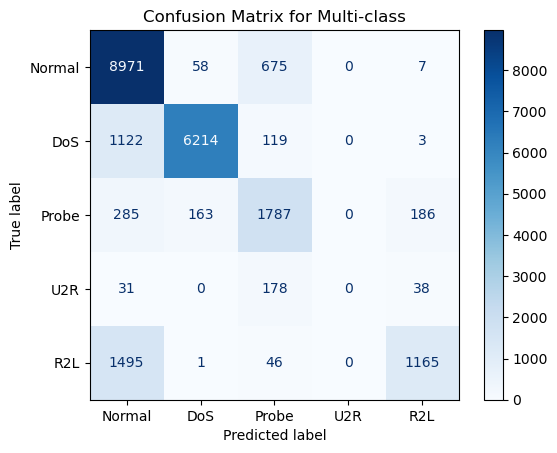

In [ ]:
# view the confusion matrix for multi-class classification

cm = confusion_matrix(y_test_mult_b.argmax(axis=1), y_rounded_pred.argmax(axis=1))
cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_fig.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Multi-class')
plt.savefig('confusion_matrix_multi-class_rs_100epochs_10patience.eps')
plt.show()